# 尝试实现线性回归
从0实现整个方法

In [1]:
from pyexpat import features
%matplotlib inline
import random
import torch
from d2l import torch as d2l

## 生成数据集
构造一个较小的人造数据集。使用线性模型参数$w = [2,-3.4]^T$、$b = 4.2$ 和 噪声$\epsilon$生成数据集及其标签
$$
y = Xw + b + \epsilon
$$

In [4]:
def synthetic_data(w, b, num_examples):
    # 生成y = Xw + b + 噪声
    # 0为均值，1为标准差，(num_examples, len(w))为样本量和样本长度
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b #作矩阵乘法
    y += torch.normal(0, 0.01, y.shape) #噪声
    return X, y.reshape((-1, 1)) #尽量使用reshape，tensor的以为向量并没有确定是行/列，这里输出y的列向量
    #reshape中参数-1为自动推断维度大小

true_w = torch.tensor([2, -3.4])
true_b = 4.2

features, labels = synthetic_data(true_w, true_b, 1000) #features = X, labels = y

`features`中的每一行都包含一个二维数据样本，`labels`中的每一行都包含一维标签值（一个标量）

In [5]:
print('features', features[0], '\nlabels', labels[0])

features tensor([ 1.5315, -0.5075]) 
labels tensor([8.9911])


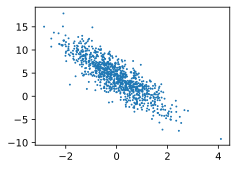

In [8]:
d2l.set_figsize()
d2l.plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1)

## 读取数据集
定义`data_iter`函数，可接受批量大小、特征矩阵和标签向量作为输入，生成大小为`batch_size`的小批量

In [9]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))

    random.shuffle(indices) #打乱列表中的顺序
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)]) #取得批量，最后可能取不完
        yield features[batch_indices], labels[batch_indices]

可以打印一小个批量
> 注：用这个方式执行效率低，只适用于教学，有专门的内置迭代器来执行此工作

In [10]:
batch_size = 10
#读一组十个数据
for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 0.7691, -1.6859],
        [ 1.7340, -1.5094],
        [-0.2582, -0.6744],
        [-0.9954,  0.7617],
        [-0.0288,  0.3814],
        [ 0.1083,  0.9984],
        [-0.3877,  1.4909],
        [-1.1415, -2.0108],
        [-1.3746,  1.2757],
        [-0.0218, -1.4384]]) 
 tensor([[11.4664],
        [12.8081],
        [ 5.9762],
        [-0.4000],
        [ 2.8446],
        [ 1.0140],
        [-1.6475],
        [ 8.7500],
        [-2.8948],
        [ 9.0409]])


## 定义模型和初始化参数

利用梯度来更新参数

In [12]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

In [13]:
def linreg(X, w, b):
    return torch.matmul(X, w) + b

## 定义损失函数

In [14]:
def squared_loss(y_hat, y):
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

## 定义优化算法
`params`是list，`lr`是学习率

In [15]:
def sgd(params, lr, batch_size):
    with torch.no_grad(): #更新时不参与梯度计算
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

## 训练过程

In [16]:
lr = 0.03
num_epochs = 3 #所有数据扫三遍
net = linreg #用于切换模型
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.046336
epoch 2, loss 0.000181
epoch 3, loss 0.000050


比较真实参数和通过训练学到的参数来评估训练的成功程度

In [17]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([ 0.0005, -0.0002], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0007], grad_fn=<RsubBackward1>)
